We use decision trees to model the data.

In [1]:
import pandas as pd
import requests
import time
import random
import string
import scipy.stats as stats
import numpy as np
import math 
from datetime import datetime


import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import plot_roc_curve

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from imblearn.pipeline import Pipeline as imbpipeline

In [2]:
# Read in data
train_final = pd.read_csv('./data/train_final.csv')
test_final = pd.read_csv('./data/test_final.csv')

# Set up X_train, y_train, X_test

X_train = train_final.drop(columns = ['Address','Block',
'Street',
'AddressNumberAndStreet',
'Latitude',
'Longitude',
'Species',
'Trap',
'AddressAccuracy',
'tot_mosquitos','WnvPresent','month_year','year', 'month',
                                     'tarsalis', 'erraticus', 'unspecified',
                                     'T040', 'T200B', 'T234', 'T090A', 'T090C',
                                     'T090B', 'T218C', 'T128A', 'T218B', 'T218A',
                                    'T002A', 'T002B', 'T200A', 'T065A'  ])
y_train = train_final['WnvPresent']
X_test = test_final.drop(columns = ['Address',
'Block',
'Street',
'AddressNumberAndStreet',
'Latitude',
'Longitude',
'Species',
'Trap',
'AddressAccuracy','Id','month_year', 'year', 'month',
                                   'tarsalis', 'erraticus', 'unspecified',
                                   'T040', 'T200B', 'T234', 'T090A', 'T090C',
                                     'T090B', 'T218C', 'T128A', 'T218B', 'T218A',
                                    'T002A', 'T002B', 'T200A', 'T065A'])

# Scale columns that need to be scaled

ss = StandardScaler()

scale_list = ['StnPressure', 'ResultSpeed','ResultDir',
              'DewPoint', 'DewPoint_roll2','DewPoint_roll3','DewPoint_roll4','DewPoint_roll5', 'DewPoint_roll6',
             'Tavg', 'Tavg_roll2','Tavg_roll3','Tavg_roll4','Tavg_roll5', 'Tavg_roll6',
             'PrecipTotal', 'PrecipTotal_roll2','PrecipTotal_roll3','PrecipTotal_roll4','PrecipTotal_roll5','PrecipTotal_roll6']

X_train[scale_list] = ss.fit_transform(X_train[scale_list])

X_test[scale_list] = ss.transform(X_test[scale_list])

# SMOTE
sm = SMOTE(sampling_strategy = {1: 8000}, random_state = 42)

# Dataframes now are Xsm_train, ysm_train and X_test

Xsm, ysm = sm.fit_resample(X_train, y_train)

Xsm_train, Xsm_val, ysm_train, ysm_val = train_test_split(Xsm, 
                                                          ysm,
                                                          test_size= 0.25,
                                                          random_state= 42,
                                                          stratify= ysm)

In [3]:
# Baseline score
ysm_train.value_counts(normalize = True)

0    0.504705
1    0.495295
Name: WnvPresent, dtype: float64

In [4]:
# Set up pipeline
dt_pipe = Pipeline([
    ('dt', DecisionTreeClassifier())
])

# Set pipe params
dt_pipe_params = {
    'dt__max_depth' : [2,3,4],
    'dt__min_samples_split': [10,20,30],
    'dt__min_samples_leaf': [2,3, 4],
}

#Instantiate Gridsearch
gs = GridSearchCV(dt_pipe, 
                  param_grid=dt_pipe_params, 
                  cv=5,
                 scoring = 'roc_auc') 

# Fit
gs.fit(Xsm_train, ysm_train)
gs_model = gs.best_estimator_

# See results
print(f'Best Grid Search Score: {gs.best_score_}')
print(f'Best Params: {gs.best_params_}')

model = gs.best_estimator_
print(f'Best Model Score: {gs_model.score(Xsm_train, ysm_train)}')
print(f'Best Model Test Score: {gs_model.score(Xsm_val,ysm_val)}')


Best Grid Search Score: 0.8137646271298564
Best Params: {'dt__max_depth': 4, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 10}
Best Model Score: 0.7607726597325408
Best Model Test Score: 0.7566229264669473


,0,1
0,Accurary,0.756623
1,Misclassification,0.243377
2,Sensitivity,0.850500
3,Specificity,0.664541
4,Precision,0.713208


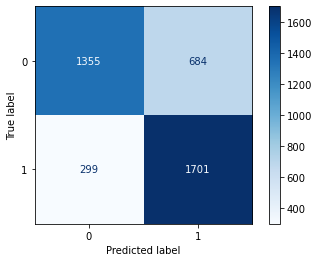

In [5]:
plot_confusion_matrix(gs_model, Xsm_val, ysm_val, cmap='Blues', values_format='d');
tn, fp, fn, tp = confusion_matrix(ysm_val, gs_model.predict(Xsm_val)).ravel()
pd.DataFrame([
    ('Accurary', (tn+tp)/(tn+tp+fp+fn)),
    ('Misclassification', (fp+fn)/(tn+tp+fp+fn)),
    ('Sensitivity', tp/(tp+fn)),
    ('Specificity', tn/(tn+fp)),
    ('Precision', tp/(tp+fp))
])

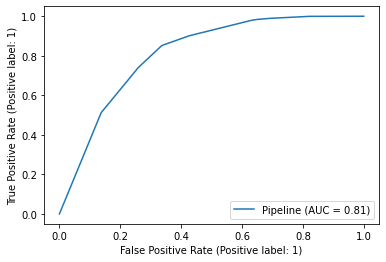

In [12]:
plot_roc_curve(gs_model, Xsm_val, ysm_val);

In [6]:
preds = gs_model.predict(X_test)

In [7]:
pred_proba = gs_model.predict_proba(X_test)

In [8]:
pred_proba

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.66763425, 0.33236575],
       [0.66763425, 0.33236575],
       [0.66763425, 0.33236575]])

In [10]:
preds = []
for i in range(0,len(pred_proba)):
    preds.append(pred_proba[i][1])

In [11]:
dt_submission_1 = pd.DataFrame()
dt_submission_1['Id'] = test_final['Id']
dt_submission_1['WnvPresent'] = preds
dt_submission_1.to_csv('./submissions/dt_submission_1.csv', index=False)

When submitted to kaggle, the score is **0.62199**.

As with other similar classifiers that undergo 'voting', the model did not fare well. The best parameters were a max depth of 4, min sample leaf of 4 and min sample split of 10. the model score was 0.760 and the validation score was 0.622. However, when submitted to kaggle, the score was 0.58836. 

This is due to the fact that such models do not have a great degree of accuracy in the predict_proba function. some of the predicted probabilities were simply [1,0] or [0.66,0.33] which were not refined enough for our model to do well on kaggle. The model also overfits on our training data as well given the large deviation between our train score and kaggle score. 

## Decision trees with imbalance pipe

We now move to use imbalance pipe

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size= 0.25,
                                                  random_state= 42,
                                                  stratify= y_train)

In [14]:
imbpipe = imbpipeline([('smote', SMOTE(random_state = 42)),
                    ('dt', DecisionTreeClassifier())
                   ])

params2 = {
    'dt__max_depth' : [2,3,4],
    'dt__min_samples_split': [10,20,30],
    'dt__min_samples_leaf': [2,3, 4],
}

gs2 = GridSearchCV(imbpipe,
                  param_grid= params2,
                  cv = 5,
                  scoring = 'roc_auc',
                  )

gs2.fit(X_train, y_train)

gs2_model = gs2.best_estimator_

In [15]:
# See results
print(f'Best Grid Search Score: {gs2.best_score_}')
print(f'Best Params: {gs2.best_params_}')

print(f'Best Model Score: {gs2_model.score(X_train, y_train)}')
print(f'Best Model Test Score: {gs2_model.score(X_val,y_val)}')


Best Grid Search Score: 0.7519231249249788
Best Params: {'dt__max_depth': 4, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 10}
Best Model Score: 0.653244540808425
Best Model Test Score: 0.6572224802601022


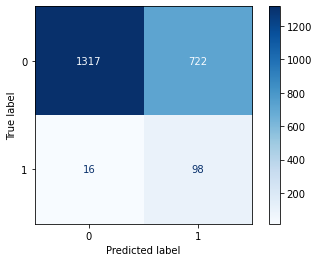

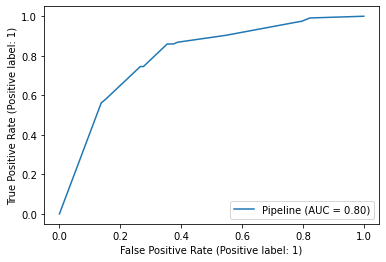

In [16]:
plot_confusion_matrix(gs2_model, X_val, y_val, cmap='Blues', values_format='d');
tn, fp, fn, tp = confusion_matrix(y_val, gs2_model.predict(X_val)).ravel()
pd.DataFrame([
    ('Accurary', (tn+tp)/(tn+tp+fp+fn)),
    ('Misclassification', (fp+fn)/(tn+tp+fp+fn)),
    ('Sensitivity', tp/(tp+fn)),
    ('Specificity', tn/(tn+fp)),
    ('Precision', tp/(tp+fp))
])

plot_roc_curve(gs2_model, X_val, y_val);

In [17]:
predict_probas = gs2_model.predict_proba(X_test)

preds = []
for i in range(0,len(predict_probas)):
    preds.append(predict_probas[i][1])
    
dt_submission_2 = pd.DataFrame()
dt_submission_2['Id'] = test_final['Id']
dt_submission_2['WnvPresent'] = preds

dt_submission_2.to_csv('./submissions/dt_submission_2.csv', index=False)

Kaggle score is 0.60934. There is no improvement in the score.